In [1]:
import csv
import datetime
import glob
import random

import pickle
import scipy.sparse
import time
import zipfile 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter

sns.set_style('whitegrid')
sns.set_palette('pastel')
sns.set_context('poster')

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
print(torch.cuda.device_count())

0


In [3]:
#old_data['train'][0]

In [4]:
with open('data/irise_weekly_and_refit.pk', 'rb') as f:
    data = pickle.load(f)
    
refit, irise = data['refit'], data['irise']

refit_weekly = [{
    'X': {k: v.iloc[168*week: 168*(week + 1)] for k, v in refit['X'].items()},
    'X_bar': refit['X_bar'].iloc[168*week: 168*(week + 1)],
    }
    for week in range(len(refit['X_bar']) // 168)
]

In [5]:
def split_data(source, target, target_houses_to_train, split, keep_target):
    if split == False:
        # Train: source+target
        return pd.concat([source, target[target_houses_to_train]], axis=1)
    if keep_target:
        # Train: target
        return target[target_houses_to_train]
    # Train: source
    return source

target_houses = irise[0]['X_bar'].columns.tolist()
target_houses_to_train = random.sample(target_houses, len(target_houses) // 2)



In [6]:
appliance_categories = list(refit_weekly[0]['X'].keys())

train = [
    {'X': {
        appliance: split_data(
            refit_weekly[week]['X'][appliance],
            irise[week]['X'][appliance],
            target_houses_to_train,
            split=False,
            keep_target=True,
        )
        for appliance in appliance_categories
    },
    'X_bar': split_data(
        refit_weekly[week]['X_bar'],
        irise[week]['X_bar'],
        target_houses_to_train,
        split=False,
        keep_target=True,
        ),}
    for week in range(min(len(refit_weekly), len(irise)))
]

test = [
    {'X': {
        appliance: split_data(
            refit_weekly[week]['X'][appliance],
            irise[week]['X'][appliance],
            target_houses_to_train,
            split=True,
            keep_target=True,
        )
        for appliance in appliance_categories
    },
    'X_bar': split_data(
        refit_weekly[week]['X_bar'],
        irise[week]['X_bar'],
        target_houses_to_train,
        split=True,
        keep_target=True,
        ),}
    for week in range(min(len(refit_weekly), len(irise)))
]

# **DSC & VSC (regular & transfer)**

### Define models

In [7]:
def rbf_kernel(x, y, gamma):
    return np.exp(-gamma * np.linalg.norm(x - y) ** 2)

def MMD(X, Y, gamma=1e-5):
    if len(X.shape) == 1:
        X = X[:, np.newaxis]
    if len(Y.shape) == 1:
        Y = Y[:, np.newaxis]
    m = X.shape[0]
    n = Y.shape[0]
    
    source_kernel_value = 1
    target_kernel_value = 1
    if m != 1:
        source_kernel_value =  sum(rbf_kernel(X[i], X[j], gamma) for i in range(m) for j in range(m) if i != j) / (m * (m - 1))
    if n != 1:
        target_kernel_value =  sum(rbf_kernel(X[i], X[j], gamma) for i in range(m) for j in range(m) if i != j) / (m * (m - 1))
    s_t_value = 2 * sum(rbf_kernel(X[i], Y[j], gamma) for i in range(m) for j in range(n)) / (m * n)

    return  np.sqrt(np.abs(source_kernel_value + target_kernel_value - s_t_value))


In [8]:
class DSC(nn.Module):
    def __init__(self, input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=False, DD_step=False, target_ind=None):
        super(DSC, self).__init__()
        self.enable_transfer_learning = enable_transfer_learning
        self.DD_step = DD_step # for now
        self.target_ind = target_ind # activates mmd directly
        self.encoder = nn.Sequential(
            nn.Conv1d(1, num_filters, filter_size, padding=filter_size//2),
            nn.ReLU(),
            nn.Conv1d(num_filters, num_filters, filter_size, padding=filter_size//2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(num_filters, num_filters, filter_size, padding=filter_size//2),
            nn.ReLU(),
            nn.ConvTranspose1d(num_filters, 1, filter_size, padding=filter_size//2),
            nn.LeakyReLU(),
        )
        #self.classifier = nn.Linear(encoding_dim, output_size)

        if self.DD_step:
            for param in self.encoder[:2].parameters():
                param.requires_grad = False

        if self.enable_transfer_learning:
            for param in self.encoder[:1].parameters():
                param.requires_grad = False
        
    def forward(self, x):
        z = self.encoder(x)
        a = z#torch.sign(z) * torch.relu(torch.abs(z) - 0.2)   # <--------- here is where the sparsity penalty occurs. The threshold is 0.01
        y_hat = self.decoder(a)
        #x_hat
        #y_hat = self.classifier(a.mean(dim=2))
        return y_hat, a, self.encoder[0].weight
    
    def loss(self, enc, dec, y):
        reconstruction_loss = torch.norm(dec - y, 'fro')
        sparsity_loss = 0.2 * torch.norm(enc, 1)
        negativity_loss = 0.1 * torch.mean(torch.clamp(-enc, min=0.0) ** 2)
        loss = sparsity_loss + negativity_loss
        mmd_loss = 0
        if self.target_ind is not None:
            mmd_loss = 1e4*MMD(
                X = enc[:self.target_ind,:,:].squeeze(0).detach().numpy(),
                Y = enc[self.target_ind:,:,:].squeeze(0).detach().numpy(),
            )
        return loss + mmd_loss

In [9]:
class DeepSC(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, code_dim, sparsity_penalty, enable_transfer_learning=False, DD_step=False):
        super(DeepSC, self).__init__()
        self.enable_transfer_learning = enable_transfer_learning
        self.DD_step = DD_step # for now

        self.sparsity_penalty = sparsity_penalty

        self.encoder = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim1, code_dim, kernel_size=3, padding=1)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(code_dim, hidden_dim1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_dim1, input_dim, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        if self.DD_step:
            for param in self.encoder[:2].parameters():
                param.requires_grad = False

        if self.enable_transfer_learning:
            for param in self.encoder[:1].parameters():
                param.requires_grad = False

    def forward(self, x):
        # Encoding
        enc = self.encoder(x)
        # Decoding
        dec = self.decoder(enc)
        return enc, dec
    
    def loss(self, x, enc, dec, y):
        reconstruction_loss = torch.norm(dec - y, 'fro')
        #criterion = nn.MSELoss()
        #reconstruction_loss = criterion(dec, y)
        sparsity_loss = self.sparsity_penalty * torch.norm(enc, 1)
        negativity_loss = 0.1 * torch.mean(torch.clamp(-enc, min=0.0) ** 2)
        loss = reconstruction_loss + sparsity_loss + negativity_loss
        return x, loss, reconstruction_loss, sparsity_loss, negativity_loss


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VSC(nn.Module):
    def __init__(self, input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=False, DD_step=False):#, beta):
        super(VSC, self).__init__()
        
        self.num_filters = num_filters
        self.encoding_dim = encoding_dim
        self.enable_transfer_learning = enable_transfer_learning
        self.DD_step = DD_step
        #self.beta = beta

        self.encoder = nn.Sequential(
            nn.Conv1d(1, num_filters, filter_size, padding=filter_size//2),
            nn.ReLU(),
            nn.Conv1d(num_filters, num_filters, filter_size, padding=filter_size//2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(num_filters, num_filters, filter_size, padding=filter_size//2),
            nn.ReLU(),
            nn.ConvTranspose1d(num_filters, 1, filter_size, padding=filter_size//2),
            nn.LeakyReLU(),
        )

        if self.DD_step:
            for param in self.encoder[:2].parameters():
                param.requires_grad = False

        if self.enable_transfer_learning:
            for param in self.encoder[:1].parameters():
                param.requires_grad = False

    def forward(self, x):
        z = self.encoder(x)
        mean = z.mean(dim=2)
        log_var = z.var(dim=2).log()
        
        # Sample from a spike and slab?*
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(z)  # not like std, more like z
        z = eps * std.unsqueeze(-1).repeat(1, 1, 170) + mean.unsqueeze(-1).repeat(1, 1, 170)

        # sparsify
        a = torch.sign(z) * F.relu(torch.abs(z) - 0.2)
        #a = a.unsqueeze(-1).repeat(1, 1, 171) # instead of repeat, smaple and create the 3rd dimension
        #print(a.shape, z.shape)
        y_hat = self.decoder(a)
        #kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        return y_hat, a, mean, log_var#, kl_loss

    def loss(self, enc, dec, y):
        reconstruction_loss = torch.norm(dec - y, 'fro')
        sparsity_loss = 0.2 * torch.norm(enc, 1)
        negativity_loss = 0.1 * torch.mean(torch.clamp(-enc, min=0.0) ** 2)
        loss = sparsity_loss + negativity_loss
        return loss

### Define training functions

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
def train_on_week_and_category(week, cat, learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=False, target_ind=None, use_only_target_for_everything=False, enable_mmd=False):
    # split data
    if enable_transfer_learning:
        X, X_t = train[week]['X_bar'].T.values[:8,:], train[week]['X_bar'].T.values[8:,:]
        y_cat, y_cat_t = train[week]['X'][cat].T.values[:8,:], train[week]['X'][cat].T.values[8:,:]
    elif use_only_target_for_everything:
        X = train[week]['X_bar'].T.values[8:,:]
        y_cat = train[week]['X'][cat].T.values[8:,:]
    else:
        X = train[week]['X_bar'].T.values
        y_cat = train[week]['X'][cat].T.values

    # 1) Deep Sparse Coding step, input and output are the same
    target_ind_for_model = target_ind if enable_mmd is True else None
    model = DSC(input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=False, target_ind=target_ind_for_model)
    model.to(device)
    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print('----> Training for', cat)
    for epoch in range(num_epochs):
        running_loss = 0.0
        inputs, targets = torch.Tensor(y_cat).unsqueeze(1).to(device), torch.Tensor(y_cat).unsqueeze(1).to(device)
        optimizer.zero_grad()

        y_hat, a, encoder = model(inputs)
        #print('a_matrix is {} % sparse'.format(round(100*len(np.where(a.cpu() < 0.1)[0])/(13*25*170), 3)))
        #print('shapes',y_hat.shape, targets.shape)
        #loss = criterion(y_hat, targets)
        loss = model.loss(a, y_hat, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print average loss for epoch (every n epochs)
        if epoch % display_every_n_epochs == 0:
            print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X)))

    weights = (model.encoder[0].weight, model.encoder[2].weight)

    ################################################################################################################################################

    #2) transfer learning
    if enable_transfer_learning:
        # model, loss and optimizer
        transfer_model = DSC(input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=True)
        transfer_model.to(device)
        transfer_criterion = nn.MSELoss()
        transfer_optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

        print('----> Transfer training for {}'.format(cat))

        for epoch in range(num_epochs):
            running_loss = 0.0
            inputs, targets = torch.Tensor(y_cat_t).unsqueeze(1).to(device), torch.Tensor(y_cat_t).unsqueeze(1).to(device)
            transfer_optimizer.zero_grad()

            transfer_model.encoder[0].weight = weights[0]
            transfer_model.encoder[2].weight = weights[1]
            #transfer_model.encoder[4].weight = model.encoder[4].weight

            y_hat, a, encoder = transfer_model(inputs)
            # Compute loss and backpropagate
            #loss = transfer_criterion(y_hat, targets)
            loss = transfer_model.loss(a, y_hat, targets)
            loss.backward()
            transfer_optimizer.step()

            running_loss += loss.item()

            # Print average loss for epoch (every n epochs)
            if epoch % display_every_n_epochs == 0:
                print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X_t)))

        weights = (transfer_model.encoder[0].weight, transfer_model.encoder[2].weight)

    ################################################################################################################################################

    #3) DD step, we freeze the encoder and take the sparse code and dictionary of the Deep Sparse Coding step
    # model, loss and optimizer
    dd_model = DSC(input_size, output_size, num_filters, filter_size, encoding_dim, DD_step=True, target_ind=target_ind_for_model)
    dd_model.to(device)
    dd_criterion = nn.MSELoss()
    dd_optimizer = optim.Adam(dd_model.parameters(), lr=0.001)

    print('----> DD step for {}'.format(cat))

    X_dd = X
    y_dd = y_cat
    if enable_transfer_learning:
        X_dd = X_t
        y_dd = y_cat_t

    for epoch in range(num_epochs):
        running_loss = 0.0
        inputs, targets = torch.Tensor(X_dd).unsqueeze(1).to(device), torch.Tensor(y_dd).unsqueeze(1).to(device)
        dd_optimizer.zero_grad()

        dd_model.encoder[0].weight = weights[0]
        dd_model.encoder[2].weight = weights[1]
        #dd_model.encoder[4].weight = model.encoder[4].weight

        y_hat, a, encoder = dd_model(inputs)
        # Compute loss and backpropagate
        #loss = dd_criterion(y_hat, targets)
        loss = dd_model.loss(a, y_hat, targets)
        loss.backward()
        dd_optimizer.step()

        running_loss += loss.item()

        # Print average loss for epoch (every n epochs)
        if epoch % display_every_n_epochs == 0:
            print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X_dd)))

    current_y_cat = y_hat.cpu().detach().numpy().T
    #if enable_transfer_learning:
    #  current_y_test_cat = transfer_model.forward(torch.Tensor(test[week]['X'][cat].T.values).unsqueeze(1).to(device))[0].cpu().detach().numpy().T
    #else:
    current_y_test_cat = dd_model.forward(torch.Tensor(test[week]['X'][cat].T.values).unsqueeze(1).to(device))[0].cpu().detach().numpy().T

    return current_y_cat, current_y_test_cat


In [13]:
def VSC_train_on_week_and_category(week, cat, learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=False, target_ind=None, use_only_target_for_everything=False, num_epochs_vsc_transfer=None):
  # split data
    if enable_transfer_learning:
        X, X_t = train[week]['X_bar'].T.values[:8,:], train[week]['X_bar'].T.values[8:,:]
        y_cat, y_cat_t = train[week]['X'][cat].T.values[:8,:], train[week]['X'][cat].T.values[8:,:]
    elif use_only_target_for_everything:
        X = train[week]['X_bar'].T.values[8:,:]
        y_cat = train[week]['X'][cat].T.values[8:,:]
    else:
        X = train[week]['X_bar'].T.values
        y_cat = train[week]['X'][cat].T.values


  # 1) Variational Sparse Coding step, input and output are the same
    model = VSC(input_size, output_size, num_filters, filter_size, encoding_dim)#, beta)
    model.to(device)
    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print('----> Training for', cat)
    for epoch in range(num_epochs):
        running_loss = 0.0
        inputs, targets = torch.Tensor(y_cat).unsqueeze(1).to(device), torch.Tensor(y_cat).unsqueeze(1).to(device)
        optimizer.zero_grad()

        y_hat, a, mean, logvar = model(inputs)

        #loss = criterion(y_hat, targets) # Reconstruction Loss, no KL divergence since this is a regression problem
        loss = model.loss(a, y_hat, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print average loss for epoch (every n epochs)
        if epoch % display_every_n_epochs == 0:
            print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X)))

    weights = (model.encoder[0].weight, model.encoder[2].weight)

################################################################################################################################################

#2) transfer learning
    if enable_transfer_learning:
        # model ,loss and optimizer
        transfer_model = VSC(input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=True)
        transfer_model.to(device)
        transfer_criterion = nn.MSELoss()
        transfer_optimizer = optim.Adam(transfer_model.parameters(), lr=0.0005)

        print('----> Transfer training for {}'.format(cat))

        for epoch in range(num_epochs_vsc_transfer):
            running_loss = 0.0
            inputs, targets = torch.Tensor(y_cat_t).unsqueeze(1).to(device), torch.Tensor(y_cat_t).unsqueeze(1).to(device)
            transfer_optimizer.zero_grad()

            transfer_model.encoder[0].weight = weights[0]
            transfer_model.encoder[2].weight = weights[1]
            #transfer_model.encoder[4].weight = model.encoder[4].weight

            y_hat, a, mean, logvar = transfer_model(inputs)

            #loss = criterion(y_hat, targets)  # Reconstruction Loss
            loss = transfer_model.loss(a, y_hat, targets)
            #loss = model.loss_function(y_hat, targets, mu, logvar, logspike, train=False)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Print average loss for epoch (every n epochs)
            if epoch % display_every_n_epochs == 0:
                print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X_t)))

        weights = (transfer_model.encoder[0].weight, transfer_model.encoder[2].weight)


################################################################################################################################################

#3) DD step, we freeze the encoder and take the sparse code and dictionary of the Deep Sparse Coding step
  # model ,loss and optimizer
    dd_model = VSC(input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=True, DD_step=True)
    dd_model.to(device)
    dd_criterion = nn.MSELoss()
    dd_optimizer = optim.Adam(dd_model.parameters(), lr=0.001)

    print('----> DD step for {}'.format(cat))

    X_dd = X
    y_dd = y_cat
    if enable_transfer_learning:
        X_dd = X_t
        y_dd = y_cat_t

    for epoch in range(num_epochs):
        running_loss = 0.0
        inputs, targets = torch.Tensor(X_dd).unsqueeze(1).to(device), torch.Tensor(y_dd).unsqueeze(1).to(device)
        dd_optimizer.zero_grad()

        dd_model.encoder[0].weight = weights[0]
        dd_model.encoder[2].weight = weights[1]
        #dd_model.encoder[4].weight = model.encoder[4].weight

        y_hat, a, mean, logvar = dd_model(inputs)
        # Compute loss and backpropagate
        #loss = dd_criterion(y_hat, targets)
        loss = dd_model.loss(a, y_hat, targets)
        loss.backward()
        dd_optimizer.step()

        running_loss += loss.item()

        # Print average loss for epoch (every n epochs)
        if epoch % display_every_n_epochs == 0:
            print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X_dd)))

    current_y_cat = y_hat.cpu().detach().numpy().T
    #if enable_transfer_learning:
    #    current_y_test_cat = transfer_model.forward(torch.Tensor(test[week]['X'][cat].T.values).unsqueeze(1).to(device))[0].cpu().detach().numpy().T
    #else:
    current_y_test_cat = model.forward(torch.Tensor(test[week]['X'][cat].T.values).unsqueeze(1).to(device))[0].cpu().detach().numpy().T

    return current_y_cat, current_y_test_cat

### Hyperparameters and variables

In [14]:
# Define hyperparameters
input_size = 168
output_size = 168
num_filters = 25
filter_size = 10
encoding_dim = 64
dsc_learning_rate = 0.001
vsc_learning_rate = 0.0005

num_epochs = 401
num_epochs_vsc_transfer = 50
nb_displays = 4
display_every_n_epochs = num_epochs // nb_displays
target_ind = 15

appliance_categories = list(train[0]['X'].keys())
weeks_to_train = len(train) - 1 #*

In [15]:
weeks_to_train = 10

# **Training blocks**

#### DSC

In [16]:
y_apps = []
y_apps_test = []
#weeks_to_train = 10 # len(train) - 1


t = time.time()
for week in range(weeks_to_train):
  print('WEEK {}'.format(week))
  current_y = dict()
  current_y_test = dict()
  for cat in appliance_categories:
    current_y_cat, current_y_test_cat = train_on_week_and_category(week, cat, dsc_learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=False)

    current_y[cat] = current_y_cat
    current_y_test[cat] = current_y_test_cat

  y_apps.append(current_y)
  y_apps_test.append(current_y_test)

print('training took {} seconds'.format(round(time.time() - t, 2)))

WEEK 0
----> Training for fridge
Epoch 0 loss: 10925.590
Epoch 100 loss: 754.649
Epoch 200 loss: 284.357
Epoch 300 loss: 197.879
Epoch 400 loss: 173.479
----> DD step for fridge
Epoch 0 loss: 1631.102
Epoch 100 loss: 1587.452
Epoch 200 loss: 1551.479
Epoch 300 loss: 1523.637
Epoch 400 loss: 1503.481
----> Training for washing_drying
Epoch 0 loss: 12719.456
Epoch 100 loss: 668.754
Epoch 200 loss: 367.376
Epoch 300 loss: 247.960
Epoch 400 loss: 192.141
----> DD step for washing_drying
Epoch 0 loss: 3586.775
Epoch 100 loss: 3544.596
Epoch 200 loss: 3505.105
Epoch 300 loss: 3468.035
Epoch 400 loss: 3433.172
----> Training for TV
Epoch 0 loss: 4541.574
Epoch 100 loss: 299.377
Epoch 200 loss: 146.329
Epoch 300 loss: 103.768
Epoch 400 loss: 85.087
----> DD step for TV
Epoch 0 loss: 2093.681
Epoch 100 loss: 2049.985
Epoch 200 loss: 2011.576
Epoch 300 loss: 1979.136
Epoch 400 loss: 1952.601
----> Training for kitchen appliances
Epoch 0 loss: 11335.289
Epoch 100 loss: 573.072
Epoch 200 loss: 306

Epoch 100 loss: 549.340
Epoch 200 loss: 343.001
Epoch 300 loss: 218.297
Epoch 400 loss: 213.555
----> DD step for kitchen appliances
Epoch 0 loss: 2428.062
Epoch 100 loss: 2368.823
Epoch 200 loss: 2313.620
Epoch 300 loss: 2262.818
Epoch 400 loss: 2216.450
WEEK 7
----> Training for fridge
Epoch 0 loss: 8992.951
Epoch 100 loss: 735.612
Epoch 200 loss: 323.409
Epoch 300 loss: 236.145
Epoch 400 loss: 204.102
----> DD step for fridge
Epoch 0 loss: 1921.075
Epoch 100 loss: 1877.248
Epoch 200 loss: 1841.286
Epoch 300 loss: 1813.671
Epoch 400 loss: 1793.885
----> Training for washing_drying
Epoch 0 loss: 10310.177
Epoch 100 loss: 435.075
Epoch 200 loss: 256.592
Epoch 300 loss: 203.063
Epoch 400 loss: 168.302
----> DD step for washing_drying
Epoch 0 loss: 5930.316
Epoch 100 loss: 5909.803
Epoch 200 loss: 5891.567
Epoch 300 loss: 5875.201
Epoch 400 loss: 5860.714
----> Training for TV
Epoch 0 loss: 2895.960
Epoch 100 loss: 235.389
Epoch 200 loss: 93.593
Epoch 300 loss: 48.882
Epoch 400 loss: 31.

In [17]:
#y_apps_test[0]['fridge'][:,:,0]

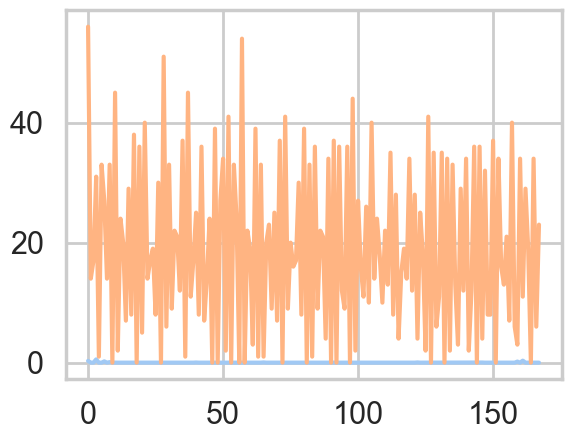

In [18]:
plt.plot(y_apps_test[0]['fridge'][:,:,0])
plt.plot(test[0]['X']['fridge'].values[:,0])


#### Transfer DSC

In [19]:
y_apps_tdsc = []
y_apps_test_tdsc = []
#weeks_to_train = 5 # len(train) - 1

for week in range(weeks_to_train):
    print('WEEK {}'.format(week))
    current_y = dict()
    current_y_test = dict()
    for cat in appliance_categories:
        current_y_cat, current_y_test_cat = train_on_week_and_category(week, cat, dsc_learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=True, target_ind=target_ind)

        current_y[cat] = current_y_cat
        current_y_test[cat] = current_y_test_cat

    y_apps_tdsc.append(current_y)
    y_apps_test_tdsc.append(current_y_test)


WEEK 0
----> Training for fridge
Epoch 0 loss: 16275.676
Epoch 100 loss: 1092.154
Epoch 200 loss: 518.807
Epoch 300 loss: 391.925
Epoch 400 loss: 412.668
----> Transfer training for fridge
Epoch 0 loss: 375.257
Epoch 100 loss: 350.184
Epoch 200 loss: 340.797
Epoch 300 loss: 337.259
Epoch 400 loss: 335.672
----> DD step for fridge
Epoch 0 loss: 2934.686
Epoch 100 loss: 2892.453
Epoch 200 loss: 2854.026
Epoch 300 loss: 2818.938
Epoch 400 loss: 2786.994
----> Training for washing_drying
Epoch 0 loss: 23333.047
Epoch 100 loss: 1032.685
Epoch 200 loss: 538.109
Epoch 300 loss: 398.501
Epoch 400 loss: 331.696
----> Transfer training for washing_drying
Epoch 0 loss: 235.038
Epoch 100 loss: 206.019
Epoch 200 loss: 202.263
Epoch 300 loss: 202.149
Epoch 400 loss: 202.145
----> DD step for washing_drying
Epoch 0 loss: 6362.197
Epoch 100 loss: 6330.162
Epoch 200 loss: 6299.592
Epoch 300 loss: 6270.165
Epoch 400 loss: 6241.715
----> Training for TV
Epoch 0 loss: 8571.721
Epoch 100 loss: 460.920
Epoc

Epoch 100 loss: 3355.850
Epoch 200 loss: 3331.915
Epoch 300 loss: 3310.415
Epoch 400 loss: 3290.771
----> Training for TV
Epoch 0 loss: 5478.494
Epoch 100 loss: 435.486
Epoch 200 loss: 234.163
Epoch 300 loss: 169.271
Epoch 400 loss: 140.701
----> Transfer training for TV
Epoch 0 loss: 114.439
Epoch 100 loss: 102.893
Epoch 200 loss: 102.655
Epoch 300 loss: 102.652
Epoch 400 loss: 102.652
----> DD step for TV
Epoch 0 loss: 3189.003
Epoch 100 loss: 3171.396
Epoch 200 loss: 3158.891
Epoch 300 loss: 3148.748
Epoch 400 loss: 3140.407
----> Training for kitchen appliances
Epoch 0 loss: 13175.583
Epoch 100 loss: 405.275
Epoch 200 loss: 273.675
Epoch 300 loss: 225.677
Epoch 400 loss: 197.630
----> Transfer training for kitchen appliances
Epoch 0 loss: 469.324
Epoch 100 loss: 441.154
Epoch 200 loss: 437.784
Epoch 300 loss: 437.709
Epoch 400 loss: 437.701
----> DD step for kitchen appliances
Epoch 0 loss: 13273.756
Epoch 100 loss: 13262.737
Epoch 200 loss: 13253.920
Epoch 300 loss: 13245.348
Epoc

Epoch 400 loss: 378.968
----> DD step for kitchen appliances
Epoch 0 loss: 11020.722
Epoch 100 loss: 11000.438
Epoch 200 loss: 10981.259
Epoch 300 loss: 10963.330
Epoch 400 loss: 10946.777
WEEK 9
----> Training for fridge
Epoch 0 loss: 14775.919
Epoch 100 loss: 989.150
Epoch 200 loss: 475.454
Epoch 300 loss: 317.644
Epoch 400 loss: 265.920
----> Transfer training for fridge
Epoch 0 loss: 298.682
Epoch 100 loss: 285.842
Epoch 200 loss: 284.577
Epoch 300 loss: 284.527
Epoch 400 loss: 284.525
----> DD step for fridge
Epoch 0 loss: 1635.824
Epoch 100 loss: 1609.692
Epoch 200 loss: 1590.541
Epoch 300 loss: 1577.038
Epoch 400 loss: 1567.510
----> Training for washing_drying
Epoch 0 loss: 17815.787
Epoch 100 loss: 537.033
Epoch 200 loss: 354.175
Epoch 300 loss: 296.336
Epoch 400 loss: 255.795
----> Transfer training for washing_drying
Epoch 0 loss: 254.302
Epoch 100 loss: 220.662
Epoch 200 loss: 216.845
Epoch 300 loss: 216.824
Epoch 400 loss: 216.821
----> DD step for washing_drying
Epoch 0 l

In [20]:
#train[0]['X_bar']

#### DSC MMD

In [21]:
y_apps_mmd = []
y_apps_test_mmd = []
#weeks_to_train = 10 # len(train) - 1

t = time.time()
for week in range(weeks_to_train):
    print('WEEK {}'.format(week))
    current_y = dict()
    current_y_test = dict()
    for cat in appliance_categories:
        current_y_cat, current_y_test_cat = train_on_week_and_category(week, cat, dsc_learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=False, target_ind=target_ind, enable_mmd=True)

        current_y[cat] = current_y_cat
        current_y_test[cat] = current_y_test_cat

    y_apps_mmd.append(current_y)
    y_apps_test_mmd.append(current_y_test)

print('training took {} seconds'.format(round(time.time() - t, 2)))

WEEK 0
----> Training for fridge
Epoch 0 loss: 12825.312
Epoch 100 loss: 1194.126
Epoch 200 loss: 575.245
Epoch 300 loss: 410.643
Epoch 400 loss: 331.532
----> DD step for fridge
Epoch 0 loss: 2830.974
Epoch 100 loss: 2792.021
Epoch 200 loss: 2757.725
Epoch 300 loss: 2728.353
Epoch 400 loss: 2703.958
----> Training for washing_drying
Epoch 0 loss: 11051.402
Epoch 100 loss: 851.156
Epoch 200 loss: 499.639
Epoch 300 loss: 355.923
Epoch 400 loss: 292.424
----> DD step for washing_drying
Epoch 0 loss: 5312.780
Epoch 100 loss: 5277.824
Epoch 200 loss: 5244.596
Epoch 300 loss: 5212.831
Epoch 400 loss: 5182.542
----> Training for TV
Epoch 0 loss: 6044.312
Epoch 100 loss: 495.950
Epoch 200 loss: 231.743
Epoch 300 loss: 163.056
Epoch 400 loss: 128.600
----> DD step for TV
Epoch 0 loss: 3037.180
Epoch 100 loss: 3001.791
Epoch 200 loss: 2970.907
Epoch 300 loss: 2944.154
Epoch 400 loss: 2921.598
----> Training for kitchen appliances
Epoch 0 loss: 11730.373
Epoch 100 loss: 954.691
Epoch 200 loss: 6

Epoch 100 loss: 506.724
Epoch 200 loss: 409.090
Epoch 300 loss: 310.876
Epoch 400 loss: 258.162
----> DD step for kitchen appliances
Epoch 0 loss: 2162.532
Epoch 100 loss: 2116.172
Epoch 200 loss: 2076.542
Epoch 300 loss: 2042.002
Epoch 400 loss: 2011.037
WEEK 7
----> Training for fridge
Epoch 0 loss: 12009.993
Epoch 100 loss: 1158.938
Epoch 200 loss: 573.877
Epoch 300 loss: 424.606
Epoch 400 loss: 381.004
----> DD step for fridge
Epoch 0 loss: 3188.434
Epoch 100 loss: 3138.610
Epoch 200 loss: 3092.998
Epoch 300 loss: 3051.919
Epoch 400 loss: 3015.648
----> Training for washing_drying
Epoch 0 loss: 9303.239
Epoch 100 loss: 703.696
Epoch 200 loss: 480.703
Epoch 300 loss: 370.908
Epoch 400 loss: 307.867
----> DD step for washing_drying
Epoch 0 loss: 6827.380
Epoch 100 loss: 6803.146
Epoch 200 loss: 6780.716
Epoch 300 loss: 6759.949
Epoch 400 loss: 6740.921
----> Training for TV
Epoch 0 loss: 5306.764
Epoch 100 loss: 513.125
Epoch 200 loss: 304.821
Epoch 300 loss: 228.539
Epoch 400 loss: 

#### VSC

In [22]:
y_apps_vsc = []
y_apps_test_vsc = []
#weeks_to_train = 2 # len(train) - 1


t = time.time()
for week in range(weeks_to_train):
  print('WEEK {}'.format(week))
  current_y = dict()
  current_y_test = dict()
  for cat in appliance_categories:
    current_y_cat, current_y_test_cat = VSC_train_on_week_and_category(week, cat, vsc_learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=False)

    current_y[cat] = current_y_cat
    current_y_test[cat] = current_y_test_cat

  y_apps_vsc.append(current_y)
  y_apps_test_vsc.append(current_y_test)

print('training took {} seconds'.format(round(time.time() - t, 2)))

WEEK 0
----> Training for fridge
Epoch 0 loss: 11658.685
Epoch 100 loss: 1426.292
Epoch 200 loss: 594.128
Epoch 300 loss: 291.197
Epoch 400 loss: 168.599
----> DD step for fridge
Epoch 0 loss: 3425.222
Epoch 100 loss: 3394.181
Epoch 200 loss: 3406.151
Epoch 300 loss: 3384.218
Epoch 400 loss: 3394.311
----> Training for washing_drying
Epoch 0 loss: 20789.188
Epoch 100 loss: 1612.523
Epoch 200 loss: 701.896
Epoch 300 loss: 411.522
Epoch 400 loss: 293.476
----> DD step for washing_drying
Epoch 0 loss: 8902.698
Epoch 100 loss: 8886.578
Epoch 200 loss: 8862.586
Epoch 300 loss: 8830.591
Epoch 400 loss: 8754.834
----> Training for TV
Epoch 0 loss: 5960.373
Epoch 100 loss: 509.123
Epoch 200 loss: 200.474
Epoch 300 loss: 96.885
Epoch 400 loss: 50.807
----> DD step for TV
Epoch 0 loss: 4273.393
Epoch 100 loss: 4260.925
Epoch 200 loss: 4267.333
Epoch 300 loss: 4243.701
Epoch 400 loss: 4239.556
----> Training for kitchen appliances
Epoch 0 loss: 20439.026
Epoch 100 loss: 1524.749
Epoch 200 loss: 6

Epoch 100 loss: 976.780
Epoch 200 loss: 485.372
Epoch 300 loss: 283.904
Epoch 400 loss: 202.165
----> DD step for kitchen appliances
Epoch 0 loss: 12079.091
Epoch 100 loss: 11999.326
Epoch 200 loss: 12045.042
Epoch 300 loss: 12070.771
Epoch 400 loss: 12015.424
WEEK 7
----> Training for fridge
Epoch 0 loss: 11539.729
Epoch 100 loss: 1434.978
Epoch 200 loss: 617.958
Epoch 300 loss: 334.220
Epoch 400 loss: 199.120
----> DD step for fridge
Epoch 0 loss: 3824.237
Epoch 100 loss: 3847.679
Epoch 200 loss: 3827.312
Epoch 300 loss: 3789.585
Epoch 400 loss: 3818.707
----> Training for washing_drying
Epoch 0 loss: 20520.979
Epoch 100 loss: 1383.352
Epoch 200 loss: 540.435
Epoch 300 loss: 319.324
Epoch 400 loss: 225.378
----> DD step for washing_drying
Epoch 0 loss: 9440.837
Epoch 100 loss: 9456.425
Epoch 200 loss: 9399.597
Epoch 300 loss: 9353.756
Epoch 400 loss: 9371.126
----> Training for TV
Epoch 0 loss: 4449.421
Epoch 100 loss: 453.634
Epoch 200 loss: 177.679
Epoch 300 loss: 85.801
Epoch 400 

#### Transfer VSC

In [23]:
y_apps_tvsc = []
y_apps_test_tvsc = []
#weeks_to_train = 5 # len(train) - 1

for week in range(weeks_to_train):
  print('WEEK {}'.format(week))
  current_y = dict()
  current_y_test = dict()
  for cat in appliance_categories:
    current_y_cat, current_y_test_cat = VSC_train_on_week_and_category(week, cat, vsc_learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=True, target_ind=target_ind, num_epochs_vsc_transfer=num_epochs_vsc_transfer)

    current_y[cat] = current_y_cat
    current_y_test[cat] = current_y_test_cat

  y_apps_tvsc.append(current_y)
  y_apps_test_tvsc.append(current_y_test)

WEEK 0
----> Training for fridge
Epoch 0 loss: 14156.623
Epoch 100 loss: 1587.379
Epoch 200 loss: 717.286
Epoch 300 loss: 409.546
Epoch 400 loss: 276.562
----> Transfer training for fridge
Epoch 0 loss: 342.317
----> DD step for fridge
Epoch 0 loss: 132782.045
Epoch 100 loss: 132111.045
Epoch 200 loss: 132897.114
Epoch 300 loss: 131647.034
Epoch 400 loss: 131503.432
----> Training for washing_drying
Epoch 0 loss: 34669.258
Epoch 100 loss: 2703.904
Epoch 200 loss: 1102.293
Epoch 300 loss: 613.976
Epoch 400 loss: 418.255
----> Transfer training for washing_drying
Epoch 0 loss: 568.693
----> DD step for washing_drying
Epoch 0 loss: 89325.608
Epoch 100 loss: 89364.909
Epoch 200 loss: 89095.619
Epoch 300 loss: 89340.239
Epoch 400 loss: 89262.023
----> Training for TV
Epoch 0 loss: 7855.858
Epoch 100 loss: 792.852
Epoch 200 loss: 299.649
Epoch 300 loss: 151.406
Epoch 400 loss: 81.654
----> Transfer training for TV
Epoch 0 loss: 40.969
----> DD step for TV
Epoch 0 loss: 97235.795
Epoch 100 lo

Epoch 100 loss: 652.183
Epoch 200 loss: 255.515
Epoch 300 loss: 115.855
Epoch 400 loss: 59.523
----> Transfer training for TV
Epoch 0 loss: 27.565
----> DD step for TV
Epoch 0 loss: 46323.812
Epoch 100 loss: 45892.619
Epoch 200 loss: 45908.938
Epoch 300 loss: 45899.080
Epoch 400 loss: 45779.074
----> Training for kitchen appliances
Epoch 0 loss: 23449.598
Epoch 100 loss: 839.119
Epoch 200 loss: 138.704
Epoch 300 loss: 109.117
Epoch 400 loss: 106.582
----> Transfer training for kitchen appliances
Epoch 0 loss: 435.988
----> DD step for kitchen appliances
Epoch 0 loss: 138628.216
Epoch 100 loss: 138951.364
Epoch 200 loss: 138833.193
Epoch 300 loss: 138266.216
Epoch 400 loss: 138738.511
WEEK 6
----> Training for fridge
Epoch 0 loss: 15729.093
Epoch 100 loss: 1871.032
Epoch 200 loss: 906.692
Epoch 300 loss: 553.502
Epoch 400 loss: 373.226
----> Transfer training for fridge
Epoch 0 loss: 366.432
----> DD step for fridge
Epoch 0 loss: 95376.182
Epoch 100 loss: 95171.756
Epoch 200 loss: 95139

# **Metrics**

In [24]:
def dd_acc_cat(y_apps, data, target_only=False):
  s = 0
  acc_dict = dict()
  for cat_ind, cat in enumerate(appliance_categories):
    y_app = y_apps[cat][:,0,:]
    if target_only:
      y_real = data['X'][cat].iloc[:,target_ind:].values
    else:
      y_real = data['X'][cat].values
    s += np.sum(np.abs(y_real - y_app), axis=0)
    acc_dict[cat] = np.sum(np.abs(y_real - y_app), axis=0)

  if target_only:
    den = 2*data['X_bar'].iloc[:,target_ind:].sum(axis=0).values
  else: 
    den = 2*data['X_bar'].sum(axis=0).values
  return np.round(1 - s/den, 3), np.round(np.mean(1 - s/den), 3), {cat: 1 - v/den for cat,v in acc_dict.items()}

def dd_acc_cat_non_zero(y_apps, data, target_only=False):
  s = 0
  total_acc = 0
  house_range = data['X_bar'].shape[1] if not target_only else data['X_bar'].shape[1] + target_ind
  for house in range(house_range):
      sum_diff = 0
      for cat_ind, cat in enumerate(appliance_categories):
          y_app = y_apps[cat][:,0,:][:, house]
          y_real = data['X'][cat].iloc[:, house].values

          non_zero_inds = np.nonzero(y_real)[0]
          sub_real = y_real[non_zero_inds]
          sub_pred = y_app[non_zero_inds]
          sum_diff += np.sum(np.abs(sub_real - np.ravel(sub_pred)))
          #s += np.sum(np.abs(y_real - y_app), axis=0)
          #acc_dict[cat] = 1 - (np.sum(np.abs(y_real - y_app), axis=0))/(2*y_real.sum(axis=0))

      den = 2*data['X_bar'].iloc[:, house].values.sum()
      total_acc += 1 - sum_diff/den
      
  return np.round(total_acc / 5, 3)

def dd_acc_cat_thresholded(y_apps, data, threshold_percentage=0.05, target_only=False):
  s = 0
  total_acc = 0
  house_range = data['X_bar'].shape[1] if not target_only else data['X_bar'].shape[1] + target_ind
  for house in range(house_range):
      sum_diff = 0
      for cat_ind, cat in enumerate(appliance_categories):
          y_app = y_apps[cat][:,0,:][:, house]
          y_real = data['X'][cat].iloc[:, house].values

          threshold = y_real.max() * threshold_percentage
          non_zero_inds = np.where(y_real > threshold)[0]

          #non_zero_inds = np.nonzero(y_real)[0]
          sub_real = y_real[non_zero_inds]
          sub_pred = y_app[non_zero_inds]
          sum_diff += np.sum(np.abs(sub_real - np.ravel(sub_pred)))
          #s += np.sum(np.abs(y_real - y_app), axis=0)
          #acc_dict[cat] = 1 - (np.sum(np.abs(y_real - y_app), axis=0))/(2*y_real.sum(axis=0))

      den = 2*data['X_bar'].iloc[:, house].values.sum()
      total_acc += 1 - sum_diff/den
      
  return np.round(total_acc / 5, 3)

average DD accuracy on weeks for Mix DSC 0.882
average DD accuracy on weeks for Transfer DSC 0.882
average DD accuracy on weeks for MMD DSC 0.881
average DD accuracy on weeks for Mix VSC 0.883
average DD accuracy on weeks for Transfer VSC 0.842


<Figure size 1500x1600 with 0 Axes>

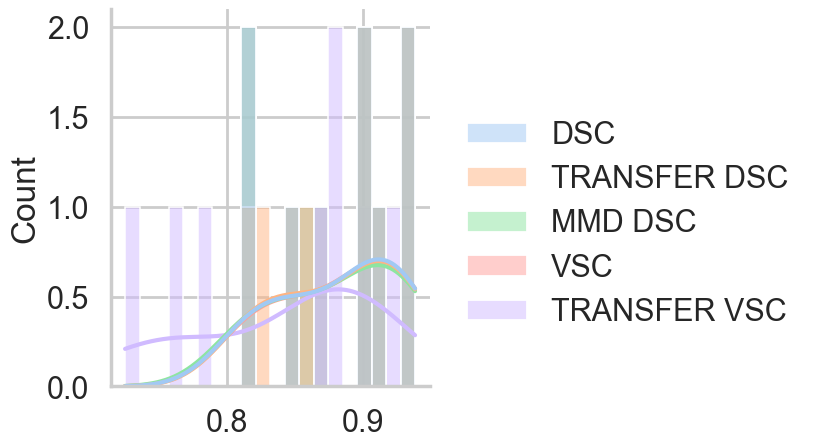

In [25]:
def overall_accs_report(weeks_to_train):
    mix_res_list = []
    transfer_res_list = []
    mmd_res_list = []
    for week in range(weeks_to_train - 1):
        mix_res_list.append(dd_acc_cat(y_apps_test[week], test[week])[1])
        transfer_res_list.append(dd_acc_cat(y_apps_test_tdsc[week], test[week])[1])
        mmd_res_list.append(dd_acc_cat(y_apps_test_mmd[week], test[week])[1])
    

    vsc_res_list = []
    tvsc_res_list = []
    for week in range(weeks_to_train - 1):
        #if week != 7: #nan for some reason
        vsc_res_list.append(dd_acc_cat(y_apps_test_vsc[week], test[week])[1])
        tvsc_res_list.append(dd_acc_cat(y_apps_test_tvsc[week], test[week])[1])

    average_df = pd.DataFrame(
      {'DSC': mix_res_list,
      'TRANSFER DSC': transfer_res_list,
      'MMD DSC': mmd_res_list,
      'VSC': vsc_res_list,# + [np.mean(vsc_res_list)], #the original week 7 was nan, need to fix
      'TRANSFER VSC': tvsc_res_list,# + [np.mean(tvsc_res_list)],
      }
      )
    plt.figure(figsize=(15,16))
    sns.displot(average_df, kde=True, bins=20)
    #plt.title('Average DD accuracy for DSC, TrDSC, VSC, TrVSC on all training weeks')
    plt.savefig(fname='Distribution of Accuracies.png')

    return round(np.mean(mix_res_list), 3), round(np.mean(transfer_res_list), 3), round(np.mean(mmd_res_list), 3), round(np.mean(vsc_res_list), 3), round(np.mean(tvsc_res_list), 3), average_df


dsc, tdsc, mmd_dsc, vsc, tvsc, av_df = overall_accs_report(weeks_to_train)
  

print('average DD accuracy on weeks for Mix DSC', dsc)
print('average DD accuracy on weeks for Transfer DSC', tdsc)
print('average DD accuracy on weeks for MMD DSC', mmd_dsc)
print('average DD accuracy on weeks for Mix VSC', vsc)
print('average DD accuracy on weeks for Transfer VSC', tvsc)


def per_cat_accs_report(weeks_to_train):
  mix_res_list = []
  transfer_res_list = []
  for week in range(weeks_to_train - 1):
    mix_res_list.append(dd_acc_cat(y_apps_test[week], test[week])[2])
    transfer_res_list.append(dd_acc_cat(y_apps_test_tdsc[week], test[week])[2])
    

  vsc_res_list = []
  tvsc_res_list = []
  for week in range(weeks_to_train - 1):
    #if week != 7: #nan for some reason
    vsc_res_list.append(dd_acc_cat(y_apps_test_vsc[week], test[week])[2])
    tvsc_res_list.append(dd_acc_cat(y_apps_test_tvsc[week], test[week])[2])

  for cat_ind, cat in enumerate(appliance_categories):
    average_df = pd.DataFrame(
        {'DSC': [item[cat] for item in mix_res_list],
        'TRANSFER DSC': [item[cat] for item in transfer_res_list],
        'TRANSFER DSC': [item[cat] for item in transfer_res_list],
        'VSC': [item[cat] for item in vsc_res_list],# + [np.mean(vsc_res_list)], #the original week 7 was nan, need to fix
        'TRANSFER VSC': [item[cat] for item in tvsc_res_list],# + [np.mean(tvsc_res_list)],
        }
        )
    plt.figure(figsize=(15,16))
    sns.displot(average_df, kde=True, bins=20)
    #plt.title('Average DD accuracy for DSC, TrDSC, VSC, TrVSC on all training weeks for {}'.format(cat))
    plt.savefig(fname='Distribution of Accuracies for {}.png'.format(cat))

  return round(np.mean([item[cat] for item in mix_res_list]), 3), round(np.mean([item[cat] for item in transfer_res_list]), 3), round(np.mean([item[cat] for item in vsc_res_list]), 3), round(np.mean([item[cat] for item in tvsc_res_list]), 3)




average DD accuracy on weeks for Mix DSC 0.707
average DD accuracy on weeks for Transfer DSC 0.707
average DD accuracy on weeks for Mix VSC 0.707
average DD accuracy on weeks for Transfer VSC 0.704


<Figure size 1500x1600 with 0 Axes>

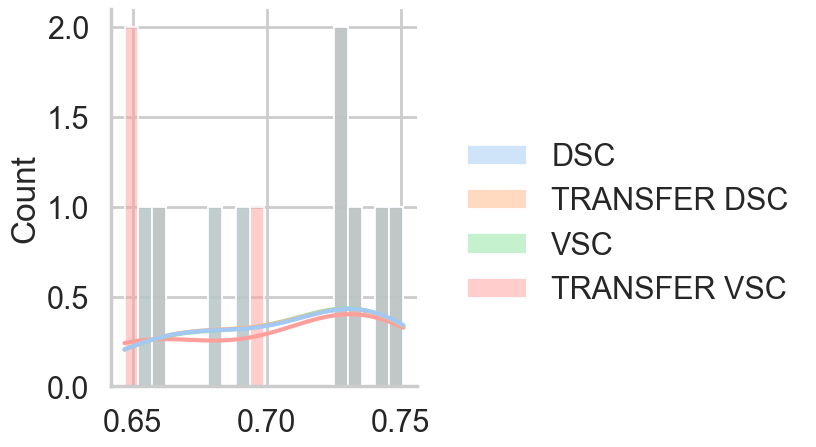

In [26]:
def overall_non_zero_accs_report(weeks_to_train):
  mix_res_list = []
  transfer_res_list = []
  for week in range(weeks_to_train - 1):
    mix_res_list.append(dd_acc_cat_non_zero(y_apps_test[week], test[week]))
    transfer_res_list.append(dd_acc_cat_non_zero(y_apps_test_tdsc[week], test[week]))
    

  vsc_res_list = []
  tvsc_res_list = []
  for week in range(weeks_to_train - 1):
    #if week != 7: #nan for some reason
    vsc_res_list.append(dd_acc_cat_non_zero(y_apps_test_vsc[week], test[week]))
    tvsc_res_list.append(dd_acc_cat_non_zero(y_apps_test_tvsc[week], test[week]))

  average_df = pd.DataFrame(
      {'DSC': mix_res_list,
      'TRANSFER DSC': transfer_res_list,
      'VSC': vsc_res_list,# + [np.mean(vsc_res_list)], #the original week 7 was nan, need to fix
      'TRANSFER VSC': tvsc_res_list,# + [np.mean(tvsc_res_list)],
      }
      )
  plt.figure(figsize=(15,16))
  sns.displot(average_df, kde=True, bins=20)
  #plt.title('Average DD accuracy for DSC, TrDSC, VSC, TrVSC on all training weeks')
  plt.savefig(fname='Distribution of Accuracies.png')

  return round(np.mean(mix_res_list), 3), round(np.mean(transfer_res_list), 3), round(np.mean(vsc_res_list), 3), round(np.mean(tvsc_res_list), 3)

dsc, tdsc, vsc, tvsc = overall_non_zero_accs_report(weeks_to_train)
  

print('average DD accuracy on weeks for Mix DSC', dsc)
print('average DD accuracy on weeks for Transfer DSC', tdsc)
print('average DD accuracy on weeks for Mix VSC', vsc)
print('average DD accuracy on weeks for Transfer VSC', tvsc)



In [27]:
from sklearn.metrics import mean_squared_error

def dd_acc_cat(y_apps, data, target_only=False):
  s = 0
  acc_dict = dict()
  for cat_ind, cat in enumerate(appliance_categories):
    y_app = y_apps[cat][:,0,:]
    if target_only:
      y_real = data['X'][cat].iloc[:,target_ind:].values
    else:
      y_real = data['X'][cat].values
    s += np.sum(np.abs(y_real - y_app), axis=0)
    acc_dict[cat] = np.sum(np.abs(y_real - y_app), axis=0)

  if target_only:
    den = 2*data['X_bar'].iloc[:,target_ind:].sum(axis=0).values
  else: 
    den = 2*data['X_bar'].sum(axis=0).values
  return np.round(1 - s/den, 3), np.round(np.mean(1 - s/den), 3), {cat: 1 - v/den for cat,v in acc_dict.items()}


week = 0
def dd_acc_per_category(y_apps, data, target_only=False):
    s = 0
    error_dict = dict()
    for cat_ind, cat in enumerate(appliance_categories):
        y_app = y_apps[cat][:,0,:]
        if target_only:
            y_real = data['X'][cat].iloc[:,target_ind:].values
        else:
            y_real = data['X'][cat].values
        s += np.sum(np.abs(y_real - y_app), axis=0)
        error_dict[cat] = np.sqrt(mean_squared_error(y_real, y_app)), np.sqrt(mean_squared_error(y_real, y_app))/np.linalg.norm(y_real, 2)
        
    return error_dict

In [28]:
def per_cat_accs_report(weeks_to_train):
  mix_res_list = []
  transfer_res_list = []
  for week in range(weeks_to_train - 1):
    mix_res_list.append(dd_acc_per_category(y_apps_test[week], test[week]))
    transfer_res_list.append(dd_acc_per_category(y_apps_test_tdsc[week], test[week]))
    

  vsc_res_list = []
  tvsc_res_list = []
  for week in range(weeks_to_train - 1):
    #if week != 7: #nan for some reason
    vsc_res_list.append(dd_acc_per_category(y_apps_test_vsc[week], test[week]))
    tvsc_res_list.append(dd_acc_per_category(y_apps_test_tvsc[week], test[week]))

  for cat_ind, cat in enumerate(appliance_categories):
    average_df = pd.DataFrame(
        {'DSC': [item[cat] for item in mix_res_list],
        'TRANSFER DSC': [item[cat] for item in transfer_res_list],
        'VSC': [item[cat] for item in vsc_res_list],# + [np.mean(vsc_res_list)], #the original week 7 was nan, need to fix
        'TRANSFER VSC': [item[cat] for item in tvsc_res_list],# + [np.mean(tvsc_res_list)],
        }
        )

  for cat in appliance_categories:
      errors_mix = [d[cat][0] for d in mix_res_list]
      print('average DSC error for {} is {}'.format(cat, np.round(np.mean(errors_mix))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in mix_res_list]), 3)))
      errors_source = [d[cat][0] for d in transfer_res_list]
      print('average T-DSC error for {} is {}'.format(cat, np.round(np.mean(errors_source))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in transfer_res_list]), 3)))
      errors_target = [d[cat][0] for d in vsc_res_list]
      print('average VSC error for {} is {}'.format(cat, np.round(np.mean(errors_target))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in vsc_res_list]), 3)))
      errors_tsc = [d[cat][0] for d in tvsc_res_list]
      print('average T-VSC error for {} is {}'.format(cat, np.round(np.mean(errors_tsc))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in tvsc_res_list]), 3)))
      print("\n")

    
  return errors_mix, errors_source, errors_target, errors_tsc


sc_cat, ssc_cat, tarsc_cat, tsc_cat = per_cat_accs_report(weeks_to_train)
  


average DSC error for fridge is 21.0 ratio is 0.044
average T-DSC error for fridge is 21.0 ratio is 0.044
average VSC error for fridge is 21.0 ratio is 0.044
average T-VSC error for fridge is 20.0 ratio is 0.043


average DSC error for washing_drying is 32.0 ratio is 0.055
average T-DSC error for washing_drying is 32.0 ratio is 0.055
average VSC error for washing_drying is 32.0 ratio is 0.055
average T-VSC error for washing_drying is 33.0 ratio is 0.056


average DSC error for TV is 8.0 ratio is 0.048
average T-DSC error for TV is 8.0 ratio is 0.048
average VSC error for TV is 8.0 ratio is 0.049
average T-VSC error for TV is 8.0 ratio is 0.047


average DSC error for kitchen appliances is 51.0 ratio is 0.051
average T-DSC error for kitchen appliances is 51.0 ratio is 0.051
average VSC error for kitchen appliances is 51.0 ratio is 0.051
average T-VSC error for kitchen appliances is 52.0 ratio is 0.052


